The pre processor is used to process all data into a suitable format for the autoencoder.

In [2]:
# PREPROCESSOR 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Loading Data from CSV
your_path = 'C:\\Users\\gusta\\Documents\\KTH\\TriOptima\\trioptima'
file_path = your_path + '/RT.IRS_CLEAN.csv'
data = pd.read_csv(file_path)

# Handling DateTime Variables
data['effectiveDate'] = pd.to_datetime(data['effectiveDate'], errors='coerce')
data['effectiveYear'] = data['effectiveDate'].dt.year
data['effectiveMonth'] = data['effectiveDate'].dt.month
data['effectiveDay'] = data['effectiveDate'].dt.day

# Drop the original 'effectiveDate' column
data = data.drop(columns=['effectiveDate'])

# Identifying variable types
numerical_vars = ['leg1FixedRate', 'leg1FixedRatePaymentFrequencyMultiplier', 'effectiveYear', 'effectiveMonth', 'effectiveDay']
categorical_vars = ['action', 'assetClass', 'leg2UnderlierTenorPeriod', 'leg2ResetFrequencyPeriod']

# Preprocessing: Numerical Variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing: Categorical Variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer: Applying transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_vars),
        ('cat', categorical_transformer, categorical_vars)
    ]
)

# Applying Preprocessing
data_preprocessed = pd.DataFrame(preprocessor.fit_transform(data))


Exporting the processed data into a .csv

In [3]:
import os

# Define the path
path = your_path

# Check if the path does not exist
if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)

# Now you can save the DataFrame
data_preprocessed.to_csv(f'{path}/processed_data.csv', index=False)



Defining the autoencoder module

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import backend as K


# Load preprocessed data
file_path = your_path + '/processed_data.csv'  # Update this path as per your directory structure
data_preprocessed = pd.read_csv(file_path, header=0)  # Ensuring the first row is treated as header

# Check to make sure the data is in expected format (all numeric, no NaN values)
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Num_Layers', 'Num_Neurons', 'Validation_Loss'])

# Set layer and neurons options
layer_options = [1, 5, 10]

for num_layers in layer_options:
    for num_neurons in [input_dim, encoding_dim, encoding_dim//2, encoding_dim//4, encoding_dim//8]:  # Example: different number of neurons
        K.clear_session()  # Clear previous models from memory.

        input_layer = layers.Input(shape=(input_dim,))
        encoder_layer = layers.Dense(num_neurons, activation='relu')(input_layer)
        
        # Add extra layers based on num_layers
        for _ in range(1, num_layers):
            encoder_layer = layers.Dense(num_neurons, activation='relu')(encoder_layer)

        decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

        # Construct and compile the autoencoder model
        autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train and evaluate the model
        history = autoencoder.fit(
            data_preprocessed, data_preprocessed,
            epochs=10,  # Adjust the number of epochs
            batch_size=32,
            shuffle=True,
            validation_split=0.1
        )
        
        # Extract the final validation loss from the training history
        final_val_loss = history.history['val_loss'][-1]

        # Append results to the DataFrame
        results_df = results_df.append({
            'Num_Layers': num_layers,
            'Num_Neurons': num_neurons,
            'Validation_Loss': final_val_loss
        }, ignore_index=True)

# Display results
print(results_df)


ModuleNotFoundError: No module named 'tensorflow'

Training the autoencoder

In [7]:
history = autoencoder.fit(
    data_preprocessed, data_preprocessed,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1  # 10% of data for validation
)


Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5218 - val_loss: 0.4606
Epoch 2/100
164/164 [==============================] - 0s 2ms/step - loss: 0.4038 - val_loss: 0.3716
Epoch 3/100
164/164 [==============================] - 0s 1ms/step - loss: 0.3478 - val_loss: 0.3305
Epoch 4/100
164/164 [==============================] - 0s 1ms/step - loss: 0.3169 - val_loss: 0.3017
Epoch 5/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2864 - val_loss: 0.2726
Epoch 6/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2629 - val_loss: 0.2526
Epoch 7/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2490 - val_loss: 0.2395
Epoch 8/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2402 - val_loss: 0.2306
Epoch 9/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2340 - val_loss: 0.2248
Epoch 10/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2294 - val_lo

Visualize the network Currently not working

In [ ]:
# Ensure the model plot is saved and displayed
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)


Anomaly detection

In [9]:
# Obtain the reconstructed data
predictions = autoencoder.predict(data_preprocessed)

# Measure the reconstruction error
mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)

# Convert mse to a DataFrame for easier handling
mse_df = pd.DataFrame({'reconstruction_error': mse})

# Display basic statistics of the error
print(mse_df.describe())


182/182 [==============================] - 0s 932us/step
       reconstruction_error
count           5804.000000
mean               0.204004
std                0.375602
min                0.001216
25%                0.033787
50%                0.098174
75%                0.213403
max                3.810315


Visualize

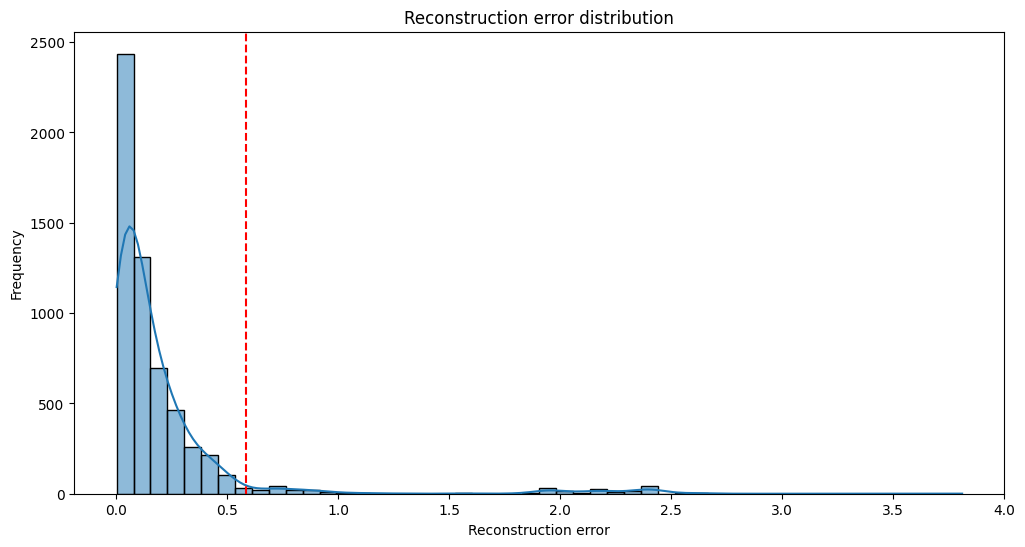

Anomaly threshold: 0.5831719939939171


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")



Test data for outliers

In [12]:
# Load new trade data from CSV
new_data_path = your_path + '/New_Trades_IRS.csv'  # Replace with the actual path to your new trade data
new_data = pd.read_csv(new_data_path)

# Repeat the same preprocessing steps for the new data
new_data['effectiveDate'] = pd.to_datetime(new_data['effectiveDate'], errors='coerce')
new_data['effectiveYear'] = new_data['effectiveDate'].dt.year
new_data['effectiveMonth'] = new_data['effectiveDate'].dt.month
new_data['effectiveDay'] = new_data['effectiveDate'].dt.day
new_data = new_data.drop(columns=['effectiveDate'])

# Apply the preprocessing transformers
new_data_preprocessed = pd.DataFrame(preprocessor.transform(new_data))  # Note: Use transform (not fit_transform) to retain the same transformations as the training data

# Predict with the autoencoder
new_predictions = autoencoder.predict(new_data_preprocessed)

# Measure the reconstruction error
new_mse = np.mean(np.power(new_data_preprocessed - new_predictions, 2), axis=1)
new_mse_df = pd.DataFrame({'reconstruction_error': new_mse})

# Set a threshold for anomaly detection (based on your training data analysis)
threshold = mse_df['reconstruction_error'].quantile(0.99)

# Determine whether each trade is an outlier or not
new_mse_df['outlier'] = new_mse_df['reconstruction_error'] > threshold

# Result: new_mse_df['outlier'] contains True for outliers and False for normal trades
print(new_mse_df)


1/1 [==============================] - 0s 20ms/step
    reconstruction_error  outlier
0               0.104038    False
1               0.247447    False
2               0.495344    False
3               0.252443    False
4               0.296163    False
5               0.207849    False
6               0.819285    False
7               0.094824    False
8               0.819881    False
9               2.384016     True
10              0.174093    False
11              0.295892    False
12              0.214374    False
13              0.071401    False
14              0.819043    False
15              2.382859     True
16              0.252261    False
17              0.008907    False
18              0.097145    False
19              0.121408    False
